/var/folders/tw/j68gkt955z57h83crjdjjrg80000gr/T/ipykernel_94599/3807883216.py:47: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))


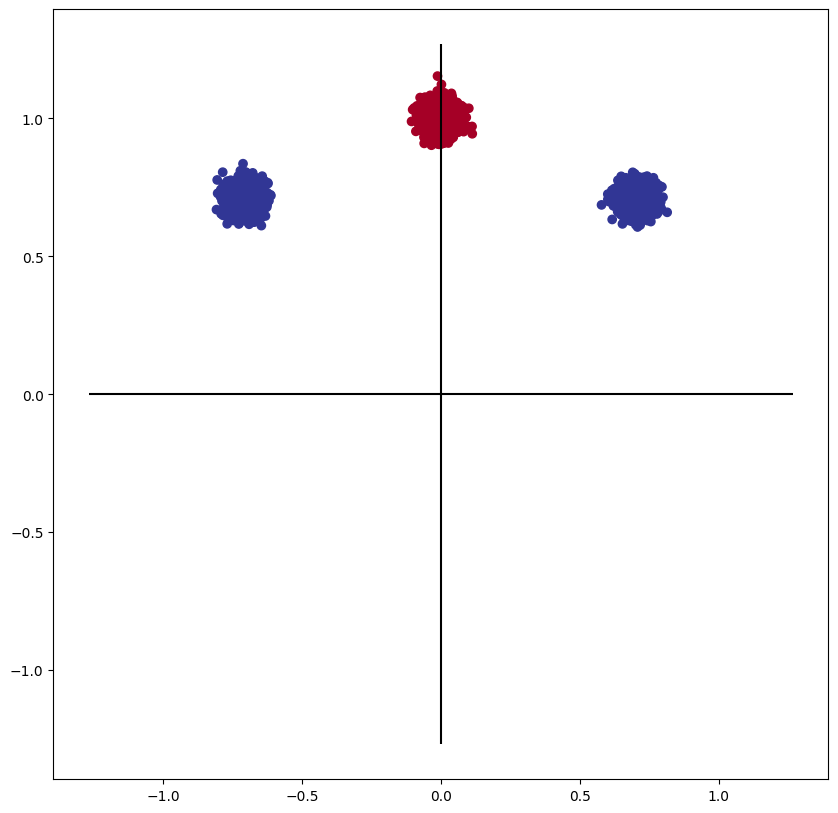

In [1]:
import os, sys, numpy, torch, matplotlib.pyplot, matplotlib.cm, ipycanvas

sys.path += [os.path.abspath(os.path.join('..')), os.path.abspath(os.path.join('../..'))]  # Allow repository modules to be imported

from settings.gaussian_clusters import get_dataloader
from utils.optimization import initialize

clusters_means = [
    [1 / 2 ** 0.5, 1 / 2 ** 0.5],
    [0, 1],
    [-1 / 2 ** 0.5, 1 / 2 ** 0.5],
]
clusters_labels = [-1., 1., -1.,]

experiment = {
    'dataset': 'gaussian_clusters',
    'seed': 1,
    'input_dimension': 2, 
    'sample_size': 5000,  
    'batch_size': 5000, 
    'within_cluster_variance': 1e-3,
    'epochs': 2000,
    'learning_rate': 0.1,
    'initial_hidden_units': 3,
    'initial_weights': [
        # input_layer
        [[-1e-5, 0.],
         [0., 1e-5],
         [1e-5, 0.],],
    ],
    'output_layer_initial_weights': [-1e-5, 1e-5, -1e-5],
    'bias': False,
    'name_parameters': ['epoch']
}
rotation_matrix = numpy.identity(experiment['input_dimension'])
device, generator = initialize(experiment['seed'])
data_args = dict(clusters_means=clusters_means, clusters_labels=clusters_labels, rotation_matrix=rotation_matrix, **experiment)
train_data, test_data = get_dataloader(**data_args), get_dataloader(**data_args)

fig, ax = matplotlib.pyplot.subplots(figsize=(10, 10))
inputs = []; labels = []
for batch_inputs, batch_labels in train_data: inputs.append(batch_inputs); labels.append(batch_labels)
inputs, labels = torch.concatenate(inputs), torch.concatenate(labels)
inputs_ = numpy.matmul(inputs.detach().cpu().numpy(), rotation_matrix.transpose())
ax.hlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.vlines(0, -inputs_.max() * 1.1, inputs_.max() * 1.1, color='k')
ax.scatter(inputs_[:, 0], inputs_[:, 1], c=labels, cmap=matplotlib.cm.get_cmap('RdYlBu_r'))

In [2]:
matplotlib.pyplot.ioff()
figure, ((input_domain_ax, loss_ax), (parameters_norms_ax, gradients_norms_ax)) = matplotlib.pyplot.subplots(2, 2, figsize=(16, 16))
canvas = ipycanvas.Canvas()
canvas.width, canvas.height = 1200, 1200
canvas.font = "30px arial"
canvas.fill_text('Results will appear as processed', canvas.width / 4, canvas.height / 3)
canvas

Canvas(height=1200, width=1200)

In [3]:
from functools import partial
from plots import plot_train_loss, plot_samples_activation_hyperplanes, plot_weights_gradient_norms, plot_weights_norms, draw_figure_into_canvas, save_figure
from utils.models import FullyConnectedNeuralNetwork
from experiment import execute_experiment

plot_samples_activation_hyperplanes = partial(plot_samples_activation_hyperplanes, ax=input_domain_ax, rotation_matrix=rotation_matrix, dataloader=train_data)
plot_train_loss = partial(plot_train_loss, ax=loss_ax)
plot_weights_norms = partial(plot_weights_norms, ax=parameters_norms_ax)
plot_weights_gradient_norms = partial(plot_weights_gradient_norms, ax=gradients_norms_ax)
draw_figure_into_canvas = partial(draw_figure_into_canvas, figure=figure, canvas=canvas)
save_figure = partial(save_figure, figure=figure, parameters=experiment, **experiment)

def model_summary(model, model_metrics, epoch, *args, **kwargs):
    for layer_index, layer in enumerate(model.layers):
        layer_metrics = {'epoch': epoch, 'layer': layer_index, 'hidden_units': layer.weight.shape[0],
                         'neurons_weights_norm': layer.weight.norm(dim=1).detach().cpu().tolist()}
        if experiment['bias']: layer_metrics.update({'biases': layer.bias.detach().cpu().tolist()})
        model_metrics.append(layer_metrics)
        
    model_metrics.append({'epoch': epoch, 'layer': len(model.layers), 'hidden_units': model.output_layer.weight.shape[1],
                          'neurons_weights_norm': model.output_layer.weight.abs().squeeze(dim=0).detach().cpu().tolist()})

execute_experiment(
    **experiment,
    train_data=train_data, 
    test_data=test_data, 
    model_class=FullyConnectedNeuralNetwork,
    saving_epochs_interval=experiment['epochs'],
    callbacks_epochs_interval=100,
    callbacks=[model_summary, plot_samples_activation_hyperplanes, plot_train_loss,
               plot_weights_norms, plot_weights_gradient_norms, draw_figure_into_canvas, save_figure]
)

/Users/LePalma/Documents/git/nns_growth/notebooks/early_neuron_alignment_data_extension/plots.py:48: RuntimeWarning: divide by zero encountered in divide
  neurons_ys = (neurons_weights[:, 0][:, None] * xs + neurons_bias[:, None]) / (- neurons_weights[:, 1][:, None])


KeyboardInterrupt: 